# 3 Queries + 3 Cyber Asset Documentations Testing

#### Neel Datta
#### August 2021

## In this notebook we will be comparing the results of the TF-IDF matching tool using the same 3 search queries on documentation for each of the following tools: 
1. [AWS Lambda](#sec1)  
2. [AWS S3](#sec2)  
3. [AWS IAM](#sec3)  

In [4]:
import json
import docsim
import re
import csv
import nltk
nltk.download('wordnet')
from urllib.request import urlopen
from urllib.error import HTTPError
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from tfidf import rank_documents
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neeldatta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/neeldatta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# File creation tool: prompts user input to write in file with inputted name.
# If file name is taken, ask to overwrite, then overwrite.
def createFile(name = None):
    home = str(Path.home())
    directory = home+"/projects/docsim/"
    
    # get fileName from user
    if (name == None):
        filename = input("Enter filename: ")
    else:
        filename = name
            
    
    filepath = directory + filename
    # Creates a new file
    with open(filepath, 'w+') as fp:
        pass
    return filename

# Function that takes in xml file of a list of URLs and converts to string list where each string is a URL
def xmlToList(xml): 
    with open(xml, 'r') as f:
        temp = f.read()
    temp = re.findall("<loc>.*?</loc>", temp)
    strlist = []
    for s in temp:
        s = s[5:-6]
        strlist.append(s)
    return strlist
    
# Function that converts list of urls into a title + Data nodes in JSON, returns JSON file name
def htmlToJSON(htmlIn):
    data = {}
    data['data'] = []
    for url in htmlIn:
        while True:
            try:
                dpoint = [url]
                page = urlopen(url)
                html = page.read().decode("ISO-8859-1")
                soup = BeautifulSoup(html)
                dpoint.append(soup.get_text())
                data['data'].append(dpoint)
                break
            except HTTPError:
                print ("HTTPError at url: " + url)
                break
    JSONout = createFile()
    with open(JSONout, 'w') as outfile:
        json.dump(data, outfile)
    return JSONout

# Function that converts the list of controls/policies from a JupiterOne PDF into a list of strings
def JSONToList(JSONin):
    policies = pd.read_json(JSONin)
    plist = []
    for sec in policies['sections']:
        for req in sec['requirements']:
            plist.append(sec['title'] + ' ' + req['ref'] + ' : ' + req['title'] + ' : ' + req['summary'])
    return plist

## Function that takes in list of queries and returns top 5 URLs for each. Writes results into csv.
def testMatchesTFIDF(queries, urls, CSVOut):
    docs = htmlToJSON(xmlToList(urls))

    with open(docs) as in_file:
        urldata = json.load(in_file)
    titles = [item[0] for item in urldata['data']]
    documents = [item[1] for item in urldata['data']]
    print(f'{len(documents)} documents')
    
    # Test on each query + Output findings into CSV file:
    with open(CSVOut, mode = 'w') as csvfile:
        csvdata = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvdata.writerow(['Policy', 'Score', 'URL'])
        for q in queries:
            document_scores = rank_documents(q, documents)
            score_titles = [(score, title) for score, title in zip(document_scores, titles)]
            print("Scores for query:\n" + q)
            for score, title in (sorted(score_titles, reverse=True, key=lambda x: x[0])[:5]):
                print(f'{score:0.3f} \t {title}')
                csvdata.writerow([q, str(score), title])               
    return

In [7]:
## First query should rank highest with Lambda, second with s3, third with IAM
QueryList = ['System Acquisition, Development and Maintenance. The organization shall supervise and monitor the activity of outsourced system development' ,
             'Operations Security. Logging facilities and log information shall be protected against tampering and unauthorized access.',
            'Access Control. Access to program source code shall be restricted.'
            ]

## Testing the cyber asset documentation/ policy query ranking one at a time, and writing results into CSV file as we go along.

In [8]:
# Creating a csv file to hold all of the data in for visualization. 
data = createFile("3Queries.csv")

In [9]:
# Writing in the header
with open(data, mode = 'w') as csvfile:
    dw = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dw.writerow(['Policy', 'Score', 'URL'])

<a id="sec1"></a>
### Testing our three queries on AWS Lambda. 

In [18]:
%%time
testMatchesTFIDF(QueryList, "AWSLambda.xml", data)

Enter filename: lambda.json
294 documents
Scores for query:
System Acquisition, Development and Maintenance. The organization shall supervise and monitor the activity of outsourced system development
0.171 	 https://docs.aws.amazon.com/lambda/latest/dg/services-efs.html
0.155 	 https://docs.aws.amazon.com/lambda/latest/dg/configuration-filesystem.html
0.105 	 https://docs.aws.amazon.com/lambda/latest/dg/powershell-devenv.html
0.081 	 https://docs.aws.amazon.com/lambda/latest/dg/lambda-powershell.html
0.059 	 https://docs.aws.amazon.com/lambda/latest/dg/welcome.html
Scores for query:
Operations Security. Logging facilities and log information shall be protected against tampering and unauthorized access.
0.125 	 https://docs.aws.amazon.com/lambda/latest/dg/monitoring-cloudwatchlogs.html
0.092 	 https://docs.aws.amazon.com/lambda/latest/dg/java-logging.html
0.089 	 https://docs.aws.amazon.com/lambda/latest/dg/nodejs-logging.html
0.085 	 https://docs.aws.amazon.com/lambda/latest/dg/powersh

In [19]:
df = pd.read_csv("3Queries.csv")
df

,Policy,Score,URL
0,"System Acquisition, Development and Maintenanc...",0.171211,https://docs.aws.amazon.com/lambda/latest/dg/s...
1,"System Acquisition, Development and Maintenanc...",0.155409,https://docs.aws.amazon.com/lambda/latest/dg/c...
2,"System Acquisition, Development and Maintenanc...",0.105005,https://docs.aws.amazon.com/lambda/latest/dg/p...
3,"System Acquisition, Development and Maintenanc...",0.080589,https://docs.aws.amazon.com/lambda/latest/dg/l...
4,"System Acquisition, Development and Maintenanc...",0.058968,https://docs.aws.amazon.com/lambda/latest/dg/w...
5,Operations Security. Logging facilities and lo...,0.124740,https://docs.aws.amazon.com/lambda/latest/dg/m...
6,Operations Security. Logging facilities and lo...,0.091915,https://docs.aws.amazon.com/lambda/latest/dg/j...
7,Operations Security. Logging facilities and lo...,0.088618,https://docs.aws.amazon.com/lambda/latest/dg/n...
8,Operations Security. Logging facilities and lo...,0.084903,https://docs.aws.amazon.com/lambda/latest/dg/p...
9,Operations Security. Logging facilities and lo...,0.084297,https://docs.aws.amazon.com/lambda/latest/dg/g...


In [20]:
df = pd.read_csv("3Queries.csv")
df['Document'] = df.URL.str.replace('https://docs.aws.amazon.com/lambda/latest/dg/', '')
df['Policy'] = df.Policy.str.replace('\. .*','.', regex = True)
df

,Policy,Score,URL,Document
0,"System Acquisition, Development and Maintenance.",0.171211,https://docs.aws.amazon.com/lambda/latest/dg/s...,services-efs.html
1,"System Acquisition, Development and Maintenance.",0.155409,https://docs.aws.amazon.com/lambda/latest/dg/c...,configuration-filesystem.html
2,"System Acquisition, Development and Maintenance.",0.105005,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-devenv.html
3,"System Acquisition, Development and Maintenance.",0.080589,https://docs.aws.amazon.com/lambda/latest/dg/l...,lambda-powershell.html
4,"System Acquisition, Development and Maintenance.",0.058968,https://docs.aws.amazon.com/lambda/latest/dg/w...,welcome.html
5,Operations Security.,0.124740,https://docs.aws.amazon.com/lambda/latest/dg/m...,monitoring-cloudwatchlogs.html
6,Operations Security.,0.091915,https://docs.aws.amazon.com/lambda/latest/dg/j...,java-logging.html
7,Operations Security.,0.088618,https://docs.aws.amazon.com/lambda/latest/dg/n...,nodejs-logging.html
8,Operations Security.,0.084903,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-logging.html
9,Operations Security.,0.084297,https://docs.aws.amazon.com/lambda/latest/dg/g...,golang-logging.html


<Figure size 8640x4320 with 0 Axes>

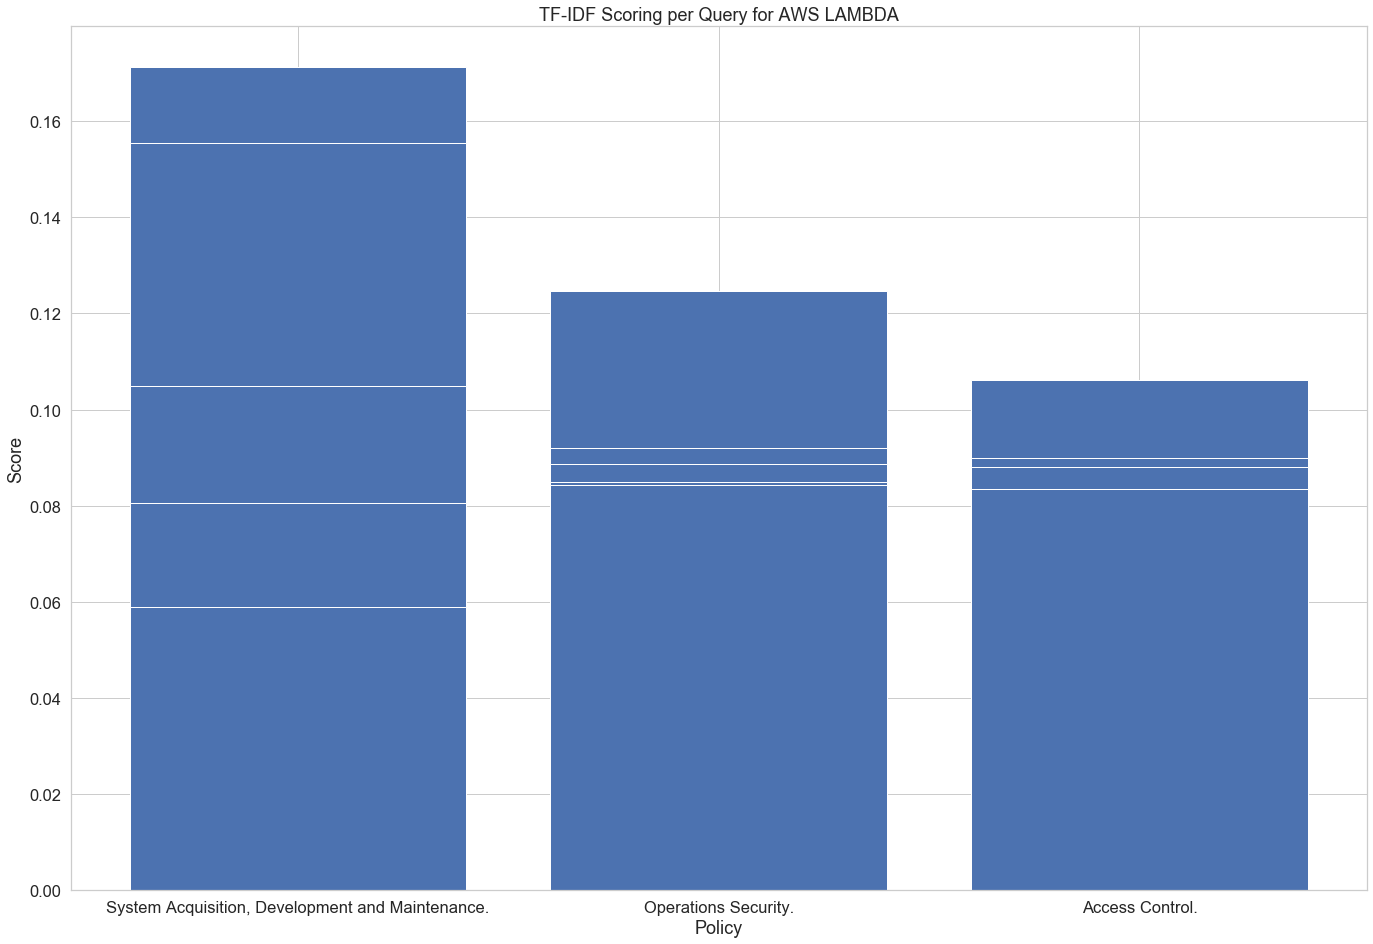

In [26]:
df = df[df['URL'].str.contains('https://docs.aws.amazon.com/lambda/latest/dg/', '')]
plt.figure(figsize=(120,60))
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
policies = df.Policy
scores = df.Score
ax.bar(policies,scores)
plt.xlabel('Policy')
plt.ylabel('Score')
plt.title("TF-IDF Scoring per Query for AWS LAMBDA")
plt.show()

#### Result is accurate as System Acquisition query ranks the highest, when not considering the outlier within the Access Control bar (as that high score matched to a single file in the Lambda documentation which pertained to AWS IAM, not Lambda itself).



In [27]:
df.sort_values('Score', ascending = False)

,Policy,Score,URL,Document
0,"System Acquisition, Development and Maintenance.",0.171211,https://docs.aws.amazon.com/lambda/latest/dg/s...,services-efs.html
1,"System Acquisition, Development and Maintenance.",0.155409,https://docs.aws.amazon.com/lambda/latest/dg/c...,configuration-filesystem.html
5,Operations Security.,0.124740,https://docs.aws.amazon.com/lambda/latest/dg/m...,monitoring-cloudwatchlogs.html
11,Access Control.,0.106068,https://docs.aws.amazon.com/lambda/latest/dg/c...,configuration-vpc.html
2,"System Acquisition, Development and Maintenance.",0.105005,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-devenv.html
6,Operations Security.,0.091915,https://docs.aws.amazon.com/lambda/latest/dg/j...,java-logging.html
12,Access Control.,0.089901,https://docs.aws.amazon.com/lambda/latest/dg/w...,welcome.html
7,Operations Security.,0.088618,https://docs.aws.amazon.com/lambda/latest/dg/n...,nodejs-logging.html
13,Access Control.,0.088131,https://docs.aws.amazon.com/lambda/latest/dg/l...,lambda-permissions.html
8,Operations Security.,0.084903,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-logging.html


In [28]:
df.sort_values('Score', ascending = False).head(1)

,Policy,Score,URL,Document
0,"System Acquisition, Development and Maintenance.",0.171211,https://docs.aws.amazon.com/lambda/latest/dg/s...,services-efs.html


As we can see here, this outlier value is attributed to the IAM troubleshooting section of the Lambda documentation, hence why we see such a strangely large score for the Access Control policy within the Lambda documentation. By removing this point and replotting the data, we can see that the System Acquisition policy holds the best match for the Lambda documentation. 

In [24]:
# WARNING! DO NOT RUN THIS MULTIPLE TIMES AS IT WILL START REMOVING OTHER DATA POINTS.
df.drop([10], inplace = True)
df

,Policy,Score,URL,Document
0,"System Acquisition, Development and Maintenance.",0.171211,https://docs.aws.amazon.com/lambda/latest/dg/s...,services-efs.html
1,"System Acquisition, Development and Maintenance.",0.155409,https://docs.aws.amazon.com/lambda/latest/dg/c...,configuration-filesystem.html
2,"System Acquisition, Development and Maintenance.",0.105005,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-devenv.html
3,"System Acquisition, Development and Maintenance.",0.080589,https://docs.aws.amazon.com/lambda/latest/dg/l...,lambda-powershell.html
4,"System Acquisition, Development and Maintenance.",0.058968,https://docs.aws.amazon.com/lambda/latest/dg/w...,welcome.html
5,Operations Security.,0.124740,https://docs.aws.amazon.com/lambda/latest/dg/m...,monitoring-cloudwatchlogs.html
6,Operations Security.,0.091915,https://docs.aws.amazon.com/lambda/latest/dg/j...,java-logging.html
7,Operations Security.,0.088618,https://docs.aws.amazon.com/lambda/latest/dg/n...,nodejs-logging.html
8,Operations Security.,0.084903,https://docs.aws.amazon.com/lambda/latest/dg/p...,powershell-logging.html
9,Operations Security.,0.084297,https://docs.aws.amazon.com/lambda/latest/dg/g...,golang-logging.html


<Figure size 8640x4320 with 0 Axes>

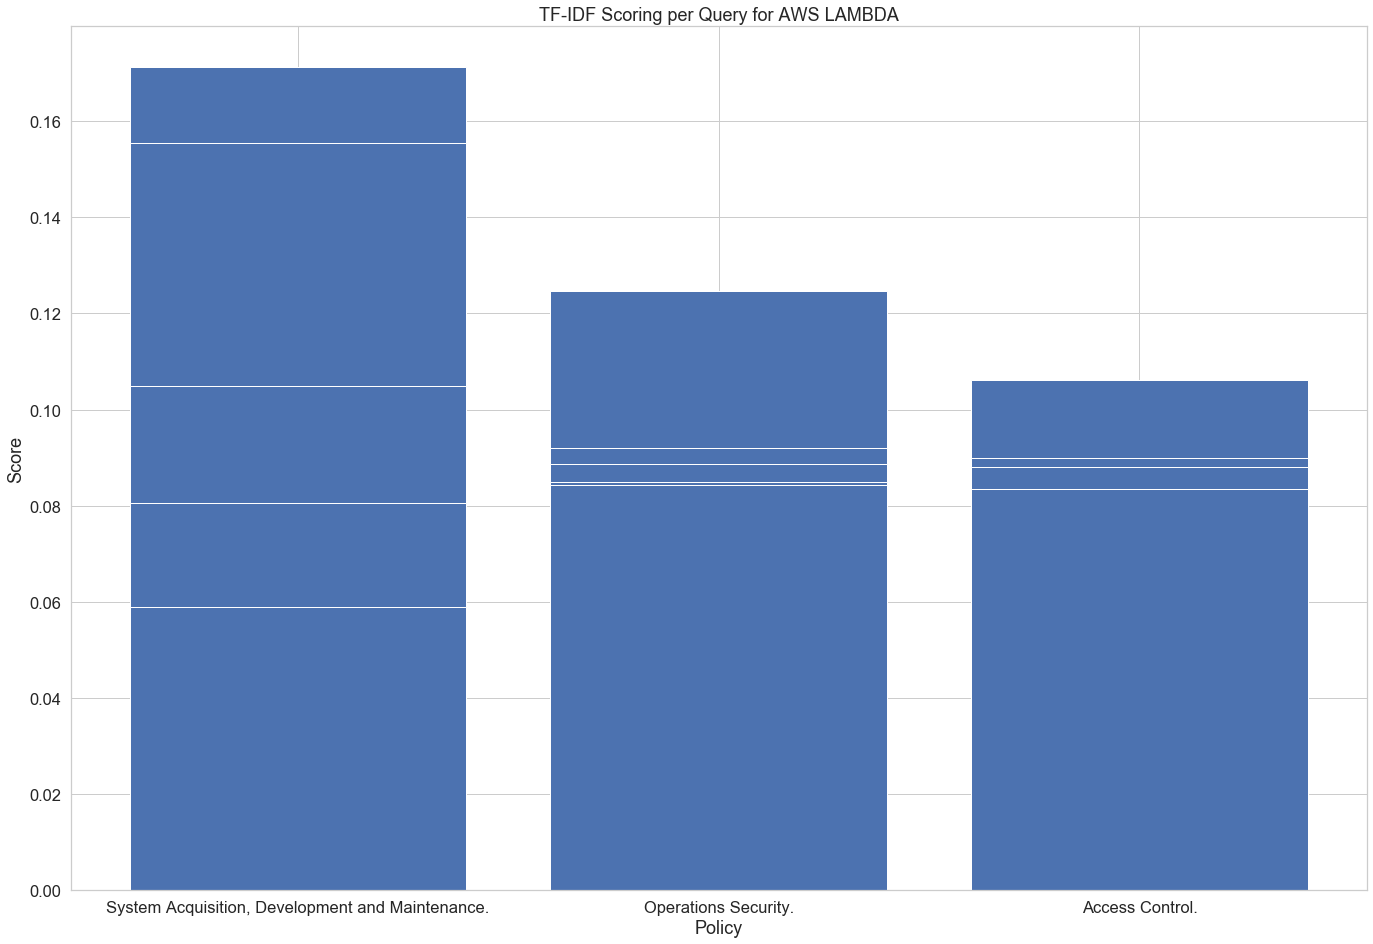

In [30]:
df = df[df['URL'].str.contains('https://docs.aws.amazon.com/lambda/latest/dg/', '')]
plt.figure(figsize=(120,60))
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
policies = df.Policy
scores = df.Score
ax.bar(policies,scores)
plt.xlabel('Policy')
plt.ylabel('Score')
plt.title("TF-IDF Scoring per Query for AWS LAMBDA")
plt.show()

### Thus we see our data correctly showing System Acquisition as the best match for Lambda documentation, using the TF-IDF ranking model!

<a id="sec2"></a>
### Testing our three queries on AWS S3. 

In [34]:
%%time
testMatchesTFIDF(QueryList, "AWSs3.xml", "3Queries.csv")

Enter filename: s3.json
356 documents
Scores for query:
System Acquisition, Development and Maintenance. The organization shall supervise and monitor the activity of outsourced system development
0.104 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/storage_lens_console_organizations_enabling_trusted_access.html
0.096 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/storage_lens_console_organizations.html
0.076 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/walkthrough1.html
0.068 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/storage_lens_with_organizations.html
0.065 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/storage_lens_iam_permissions.html
Scores for query:
Operations Security. Logging facilities and log information shall be protected against tampering and unauthorized access.
0.231 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/ServerLogs.html
0.219 	 https://docs.aws.amazon.com/AmazonS3/latest/userguide/logging-with-S3.html


In [35]:
df = pd.read_csv("3Queries.csv")
df['Document'] = df.URL.str.replace('https://docs.aws.amazon.com/AmazonS3/latest/userguide/', '')
df['Policy'] = df.Policy.str.replace('\. .*','.', regex = True)

<Figure size 8640x4320 with 0 Axes>

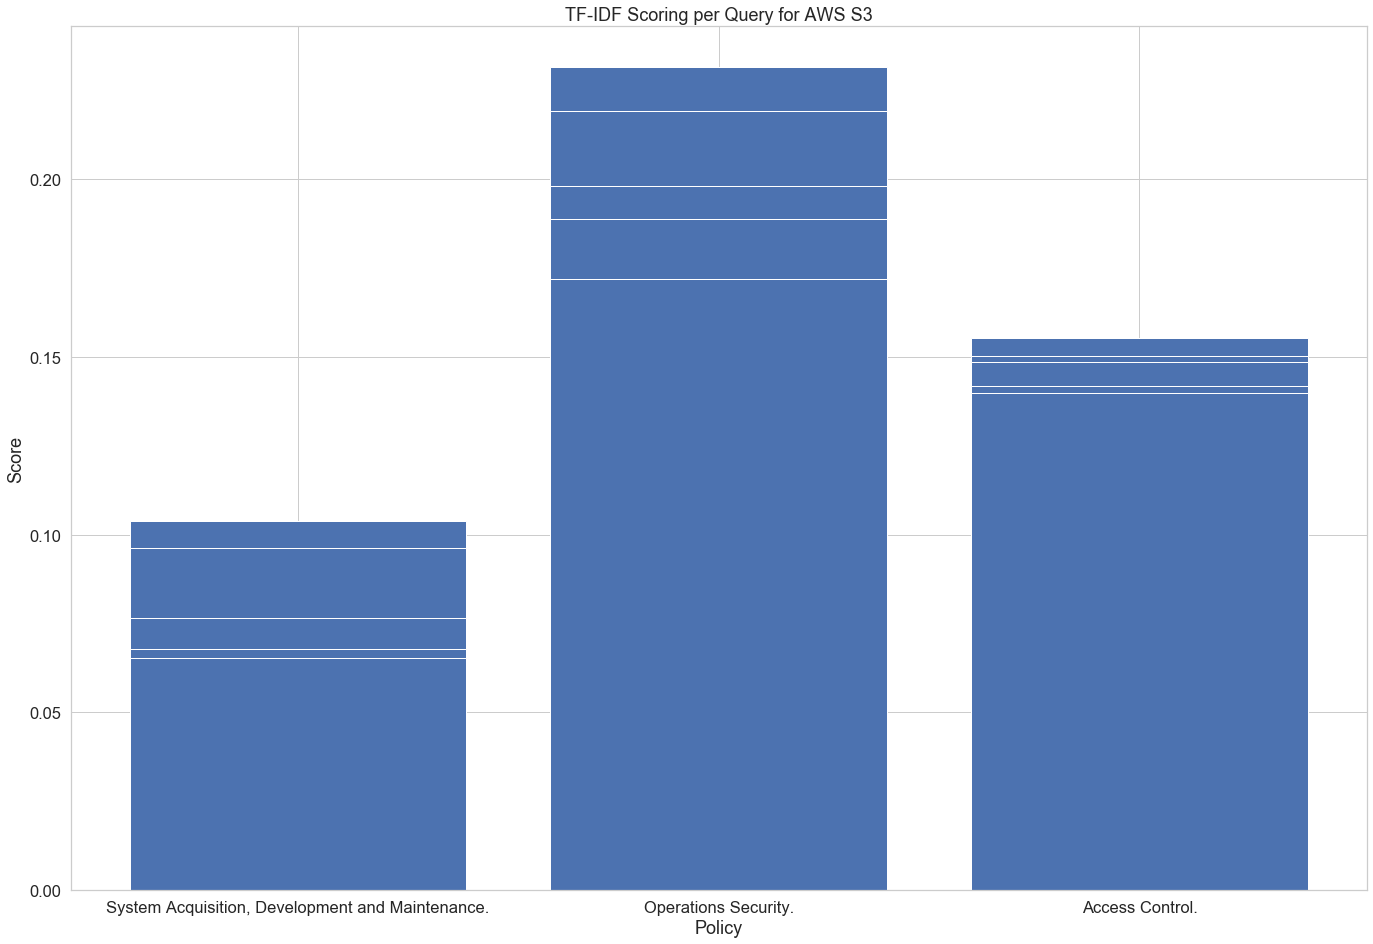

In [36]:
df = df[df['URL'].str.contains('https://docs.aws.amazon.com/AmazonS3/latest/userguide/')]
plt.figure(figsize=(120,60))
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
policies = df.Policy
scores = df.Score
ax.bar(policies,scores)
plt.xlabel('Policy')
plt.ylabel('Score')
plt.title("TF-IDF Scoring per Query for AWS S3")
plt.show()

### We see our data correctly showing Operations Security as the best match for S3 documentation.

<a id="sec3"></a>
### Testing our three queries on AWS IAM.

In [37]:
%%time
testMatchesTFIDF(QueryList, "IAMurlsexample.xml", "3Queries.csv")

HTTPError at url: https://docs.aws.amazon.com/IAM/latest/service-authorization/latest/reference/reference_policies_actions-resources-contextkeys.html
HTTPError at url: https://docs.aws.amazon.com/IAM/latest/service-authorization/latest/reference/list_awssecretsmanager.html
HTTPError at url: https://docs.aws.amazon.com/IAM/latest/service-authorization/latest/reference/list_awskeymanagementservice.html
HTTPError at url: https://docs.aws.amazon.com/IAM/latest/service-authorization/latest/reference/list_identityandaccessmanagement.html
Enter filename: iam.json
485 documents
Scores for query:
System Acquisition, Development and Maintenance. The organization shall supervise and monitor the activity of outsourced system development
0.138 	 https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_common-scenarios_aws-accounts.html
0.119 	 https://docs.aws.amazon.com/IAM/latest/UserGuide/access_policies_generate-policy.html
0.107 	 https://docs.aws.amazon.com/IAM/latest/UserGuide/access_polici

In [38]:
df = pd.read_csv("3Queries.csv")
df['Document'] = df.URL.str.replace('https://docs.aws.amazon.com/IAM/latest/','')
df['Policy'] = df.Policy.str.replace('\. .*','.', regex = True)

<Figure size 8640x4320 with 0 Axes>

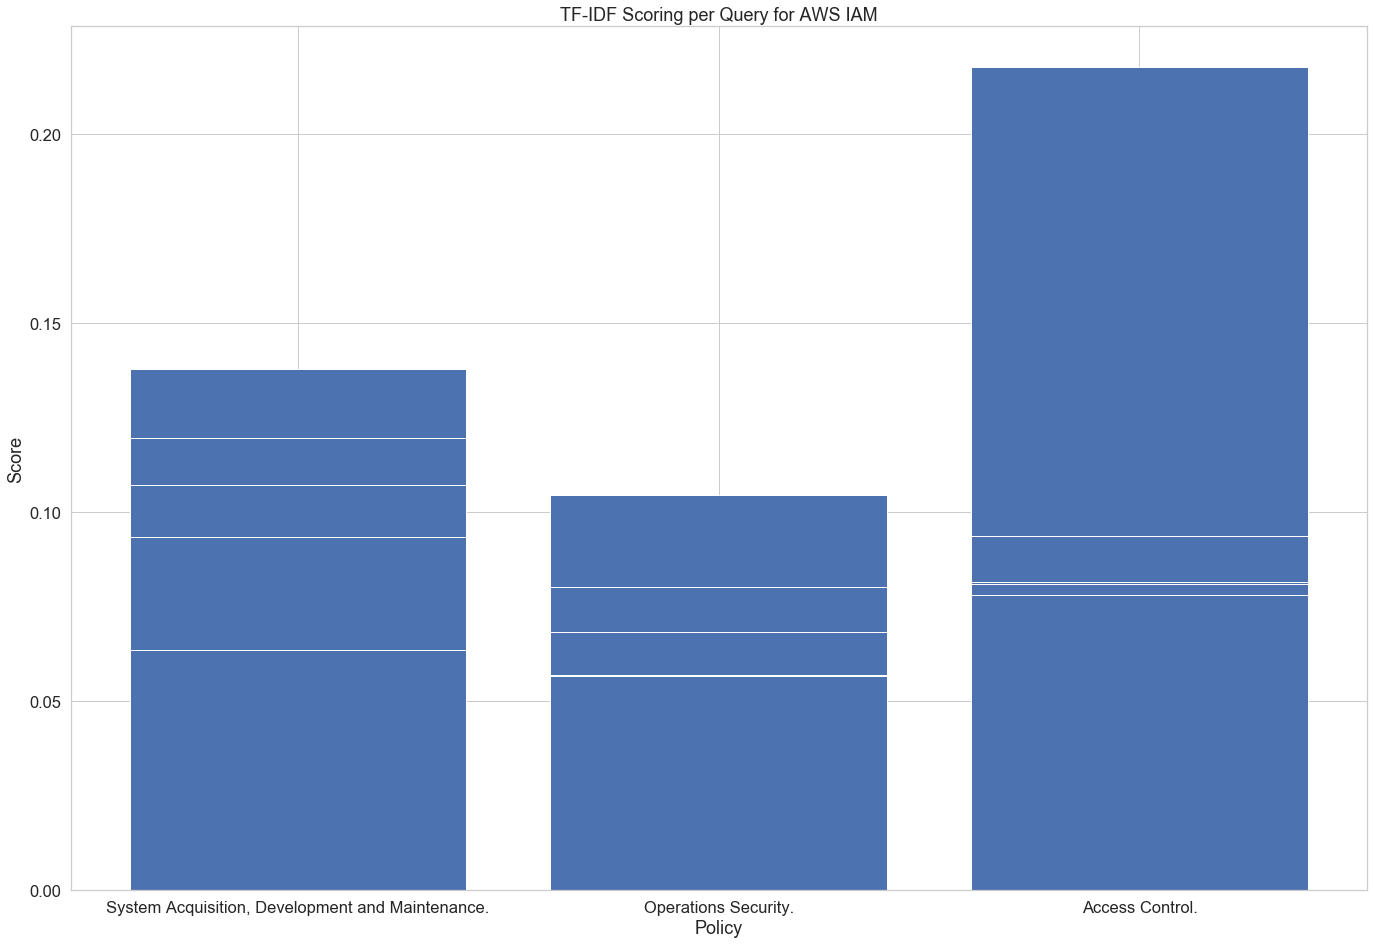

In [39]:
df = df[df['URL'].str.contains('https://docs.aws.amazon.com/IAM/latest/', '')]
plt.figure(figsize=(120,60))
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
policies = df.Policy
scores = df.Score
ax.bar(policies,scores)
plt.xlabel('Policy')
plt.ylabel('Score')
plt.title("TF-IDF Scoring per Query for AWS IAM")
plt.show()

### We see our data correctly showing Access Control as the best match for IAM documentation.

# Overall, TF IDF tool shows promising results when used to compare security policies to application documentations.